## 1. import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
from sklearn.model_selection import train_test_split
from collections import Counter
import hanja
from hanja import hangul

In [2]:
# pip install tensorflow

In [3]:
# pip install konlpy

In [4]:
# pip install hanja

## 2. 데이터 불러오기

In [5]:
newsdata = pd.read_csv("../data/Newsfile3.csv", encoding='euc-kr')
newsdata.tail(3)

,date,title
58439,20151019,"[특징주]제주반도체, 美·中 대규모 투자유치에 '上'"
58440,20151019,[반도체] 2016 반도체 투자 감소 예상 - 미래
58441,20151019,"제주반도체, '해외투자유치설' 조회공시 요구"


## 3. 데이터 확인

In [6]:
newsdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58442 entries, 0 to 58441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    58442 non-null  int64 
 1   title   58442 non-null  object
dtypes: int64(1), object(1)
memory usage: 913.3+ KB


In [7]:
# 결측치 확인
newsdata.isnull().sum()

date     0
title    0
dtype: int64

## 4. train, test dataset 생성

In [8]:
# train, test set 분리
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(newsdata)

### 4-1. train_data

In [9]:
# train_data 확인
train_data.head(2)

,date,title
15767,20210312,반도체 부족 여파에 제조장비도 '쇼티지'…몸값 올라
11720,20210515,차량용 반도체 '대란'인데…삼성이 안나서는 이유 [박신영의 일렉트로맨]


In [10]:
# train_data shape 확인
train_data.shape

(43831, 2)

### 4-2. test_data

In [11]:
# test_data 확인
test_data.head(2)

,date,title
6288,20211008,삼성전자 3Q 매출 73조 '역대 최대'…반도체가 끌고 스마트폰이 밀었다
26803,20191212,"한은 ""韓 반도체 수출, 내년 중반 회복국면"""


In [12]:
# test_data shape 확인
test_data.shape

(14611, 2)

## 5. 데이터 전처리

### 5-1. train_data

- 한글, 영어, 숫자, 한자 이외의 문자열 제거

In [13]:
train_data["title"] = train_data["title"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣|A-Za-z|一-龥 ]", "")

- 한자가 들어간 데이터 확인

In [14]:
from collections import Counter

In [15]:
train_hanja_data = train_data.copy()

In [16]:
pattern = re.compile('[一-龥]')
# 한자 리스트 확인
hanja_list = train_hanja_data["title"].str.findall(pattern).sum()
# 빈도수가 높은 한자 체크
Counter(hanja_list).most_common()[:5]

[('美', 2107), ('中', 1868), ('車', 1393), ('日', 1080), ('韓', 960)]

In [17]:
# 한자 중복값 제거 확인
new_list = []
for i in hanja_list:
    if i not in new_list:
        new_list.append(i)
print(new_list)

['外', '對', '中', '韓', '弗', '美', '文', '車', '比', '株', '民', '官', '證', '三', '電', '日', '新', '發', '强', '訪', '硏', '上', '兆', '企', '來', '好', '行', '無', '風', '前', '燈', '火', '苦', '全', '價', '獨', '社', '人', '稅', '臺', '與', '公', '他', '紙', '英', '式', '年', '非', '西', '安', '勝', '銀', '協', '王', '和', '法', '課', '大', '亞', '乙', '故', '飛', '月', '益', '高', '崔', '辛', '甲', '市', '軍', '克', '船', '鐵', '後', '戰', '靑', '告', '超', '業', '委', '脫', '場', '現', '居', '思', '危', '說', '佛', '富', '反', '島', '政', '號', '氣', '光', '低', '下', '道', '延', '國', '産', '女', '難', '街', '經', '北', '喜', '悲', '向', '化', '毒', '訴', '賞', '恨', '差', '異', '選', '力', '重', '伊', '本', '自', '害', '尹', '材', '家', '孝', '史', '次', '弱', '亂', '印', '多', '功', '論', '敵', '濠', '先', '共', '報', '守', '城', '純', '水', '格', '信', '有', '烹', '學', '華', '談', '投', '心', '週', '油', '者', '朴', '親', '事', '萬', '檢', '逆', '石', '災', '刮', '目', '相', '順', '輸', '母', '路', '面', '問', '錢', '種', '加', '色', '用', '熱']


- `한자 -> 한글로 대체`
    - 뉴스 제목에 사용되는 한자들은 의미를 축약한 한 글자로 구성된 한자가 많은 것으로 추측됨
    - 한자 -> 한글로 단순 번역하는 방법을 시도

In [18]:
train_data["title"] = train_data["title"].apply(lambda x: hanja.translate(x, "substitution"))

In [19]:
train_data.head(3)

,date,title
15767,20210312,반도체 부족 여파에 제조장비도 쇼티지몸값 올라
11720,20210515,차량용 반도체 대란인데삼성이 안나서는 이유 박신영의 일렉트로맨
48490,20170911,특징주아이에이 자동차용 전력반도체 국산화 성공 소식에 상승


### 5-2. test_data

- 한글, 영어, 숫자, 한자 이외의 문자열 제거

In [20]:
test_data["title"] = test_data["title"].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣|A-Za-z|一-龥 ]", "")

In [21]:
test_hanja_data = test_data.copy()

In [22]:
pattern = re.compile('[一-龥]')
# 한자 리스트 확인
hanja_list2 = test_hanja_data["title"].str.findall(pattern).sum()
# 빈도수가 높은 한자 체크
Counter(hanja_list2).most_common()[:5]

[('美', 682), ('中', 642), ('車', 428), ('日', 362), ('韓', 318)]

- 한자가 들어간 데이터 확인

In [23]:
# 한자 중복값 제거 확인
new_list = []
for i in hanja_list2:
    if i not in new_list:
        new_list.append(i)
print(new_list)

['韓', '中', '論', '新', '車', '株', '美', '日', '人', '事', '萬', '弗', '外', '對', '産', '硏', '兆', '證', '無', '文', '企', '年', '前', '電', '乙', '臺', '比', '三', '獨', '高', '委', '通', '行', '來', '社', '價', '發', '益', '尹', '脫', '好', '會', '名', '家', '週', '非', '英', '式', '協', '市', '油', '化', '與', '號', '伊', '靑', '全', '稅', '石', '訴', '逆', '夢', '設', '檢', '亞', '戰', '亂', '銀', '者', '光', '談', '枯', '死', '佛', '大', '曰', '火', '順', '癌', '位', '相', '故', '塞', '翁', '之', '馬', '克', '水', '洪', '先', '後', '昌', '星', '甲', '重', '內', '難', '反', '上', '說', '結', '氣', '販', '禁', '超', '神', '展', '華', '種', '裝', '月', '用', '强', '州', '低', '王', '場', '多', '訪']


- `한자 -> 한글로 대체`

In [24]:
test_data["title"] = test_data["title"].apply(lambda x: hanja.translate(x, "substitution"))

In [25]:
test_data.head(3)

,date,title
6288,20211008,삼성전자 Q 매출 조 역대 최대반도체가 끌고 스마트폰이 밀었다
26803,20191212,한은 한 반도체 수출 내년 중반 회복국면
17919,20210113,유진테크 SK하이닉스와 반도체 제조장비 공급 계약


## 6. 명사만 추출한 컬럼 추가

- Okt 에러내용 : JVMNotFoundException: No JVM shared library file (jvm.dll) found.
    - 참고 : https://stricky.tistory.com/398

- 오라클 JDK 다운로드 사이트 :  https://www.oracle.com/java/technologies/downloads/#java8

- 설치 경로 확인 > 시스템 환경 변수에 추가 > 변수이름 `JAVA_HOME`으로 저장

In [26]:
# python bit 확인
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


### 6-1. train_data

In [27]:
okt = Okt()
n_ = []
title_rename = []
for i in range(len(train_data)):
    if (i % 2000 == 0):
        print(i, "단계완료")
    n_.append(' '.join(okt.nouns(train_data.iloc[i]["title"])))


# 명사 추출 컬럼 
train_data["nouns"] = n_

# empty space가 아닌 nouns 컬럼만 train_data에 저장
train_data = train_data[train_data["nouns"] != ''] 

0 단계완료
2000 단계완료
4000 단계완료
6000 단계완료
8000 단계완료
10000 단계완료
12000 단계완료
14000 단계완료
16000 단계완료
18000 단계완료
20000 단계완료
22000 단계완료
24000 단계완료
26000 단계완료
28000 단계완료
30000 단계완료
32000 단계완료
34000 단계완료
36000 단계완료
38000 단계완료
40000 단계완료
42000 단계완료


In [28]:
train_data.head(3)

,date,title,nouns
15767,20210312,반도체 부족 여파에 제조장비도 쇼티지몸값 올라,반도체 부족 여파 장비 쇼티 몸값
11720,20210515,차량용 반도체 대란인데삼성이 안나서는 이유 박신영의 일렉트로맨,차량 용 반도체 대란 삼성 이유 박신영 일렉트로 맨
48490,20170911,특징주아이에이 자동차용 전력반도체 국산화 성공 소식에 상승,특징 아이 에이 자동 차용 전력 반도체 국산 성공 소식 상승


### 6-2. test_data

In [29]:
okt = Okt()
n_ = []
title_rename = []
for i in range(len(test_data)):
    if (i % 2000 == 0):
        print(i, "단계완료")
    n_.append(' '.join(okt.nouns(test_data.iloc[i]["title"])))


# 명사 추출 컬럼 
test_data["nouns"] = n_

# empty space가 아닌 nouns 컬럼만 test_data에 저장
test_data = test_data[test_data["nouns"] != ''] 

0 단계완료
2000 단계완료
4000 단계완료
6000 단계완료
8000 단계완료
10000 단계완료
12000 단계완료
14000 단계완료


In [30]:
test_data.head(3)

,date,title,nouns
6288,20211008,삼성전자 Q 매출 조 역대 최대반도체가 끌고 스마트폰이 밀었다,삼성 전자 매출 조 역대 최대 반도체 끌 스마트폰
26803,20191212,한은 한 반도체 수출 내년 중반 회복국면,은 반도체 수출 내년 중반 회복 국면
17919,20210113,유진테크 SK하이닉스와 반도체 제조장비 공급 계약,유진 테크 하이닉스 반도체 제조 장비 공급 계약


In [31]:
train_data.to_csv('../data/train_data_hanja_translate.csv')

In [32]:
test_data.to_csv('../data/test_data_hanja_translate.csv')

## 7. 워드 클라우드

### 7-1. train_data

In [33]:
# train_data > nouns 컬럼 > 0번째 데이터의 단어 출력
train_data.nouns.to_list()[0].split()

['반도체', '부족', '여파', '장비', '쇼티', '몸값']

In [34]:
# train_data의 길이 확인
len(train_data.nouns.to_list())

43831

In [35]:
nouns_list = []

for i in range(0, len(train_data.nouns.to_list())):
    noun = train_data.nouns.to_list()[i].split()
    nouns_list.append(noun)

In [36]:
nouns_list[:5]

[['반도체', '부족', '여파', '장비', '쇼티', '몸값'],
 ['차량', '용', '반도체', '대란', '삼성', '이유', '박신영', '일렉트로', '맨'],
 ['특징', '아이', '에이', '자동', '차용', '전력', '반도체', '국산', '성공', '소식', '상승'],
 ['반도체', '호황', '월', '수출', '물량', '지수', '개월', '연속', '상승'],
 ['브리핑', '뷰웍스', '반도체', '검사', '카메라', '시리즈', '출시', '외']]

In [37]:
len(nouns_list)

43831

In [38]:
nouns_list[0]

['반도체', '부족', '여파', '장비', '쇼티', '몸값']

In [39]:
nouns_list[1]

['차량', '용', '반도체', '대란', '삼성', '이유', '박신영', '일렉트로', '맨']

In [40]:
nouns_list[0] + nouns_list[1]

['반도체',
 '부족',
 '여파',
 '장비',
 '쇼티',
 '몸값',
 '차량',
 '용',
 '반도체',
 '대란',
 '삼성',
 '이유',
 '박신영',
 '일렉트로',
 '맨']

In [41]:
sum = []

for i in range(0, len(nouns_list)):
    sum += nouns_list[i]

In [42]:
sum

['반도체',
 '부족',
 '여파',
 '장비',
 '쇼티',
 '몸값',
 '차량',
 '용',
 '반도체',
 '대란',
 '삼성',
 '이유',
 '박신영',
 '일렉트로',
 '맨',
 '특징',
 '아이',
 '에이',
 '자동',
 '차용',
 '전력',
 '반도체',
 '국산',
 '성공',
 '소식',
 '상승',
 '반도체',
 '호황',
 '월',
 '수출',
 '물량',
 '지수',
 '개월',
 '연속',
 '상승',
 '브리핑',
 '뷰웍스',
 '반도체',
 '검사',
 '카메라',
 '시리즈',
 '출시',
 '외',
 '삼성',
 '전세계',
 '반도체',
 '업체',
 '최초',
 '전',
 '사업',
 '탄소',
 '물',
 '폐기물',
 '감',
 '인증',
 '한미',
 '반도체',
 '영업',
 '익',
 '억',
 '증가',
 '씨',
 '앤지',
 '하이테크',
 '전자',
 '억',
 '규모',
 '반도체',
 '장비',
 '공급',
 '계약',
 '홍',
 '용인',
 '반도체',
 '클러스터',
 '년',
 '부가가치',
 '조원',
 '창',
 '아이',
 '텍',
 '반도체',
 '전일',
 '대비',
 '약',
 '상승',
 '원',
 '삼성',
 '반도체',
 '실패',
 '장담',
 '일본',
 '역사',
 '년',
 '그날',
 '인텔',
 '독일',
 '또',
 '반도체',
 '공장',
 '삼성',
 '언제',
 '유니',
 '테스트',
 '대만',
 '난',
 '테크놀로지',
 '억원',
 '규모',
 '반도체',
 '장비',
 '공급',
 '계약',
 '유니',
 '테스트',
 '반도체',
 '검사',
 '장비',
 '공급',
 '계약',
 '글로벌',
 '반도',
 '체사',
 '작년',
 '투자',
 '비중',
 '삼성',
 '조원',
 '투자',
 '하이닉스',
 '반도체',
 '혁신',
 '아이디어',
 '공모전',
 '개최',
 '슈나이더',
 '렉',
 '트릭',
 '반도체',
 '공장

In [45]:
# 가장 많이 나온 단어 100개 저장
counts = Counter(sum)
tags = counts.most_common(30000)
tags

[('반도체', 44822),
 ('삼성', 9162),
 ('전자', 6536),
 ('수출', 4510),
 ('장비', 3608),
 ('투자', 3339),
 ('공급', 2995),
 ('하이닉스', 2701),
 ('분기', 2478),
 ('계약', 2320),
 ('규모', 2280),
 ('억', 2256),
 ('월', 2072),
 ('차', 2033),
 ('년', 1962),
 ('주', 1843),
 ('중', 1837),
 ('일', 1820),
 ('실적', 1814),
 ('공장', 1811),
 ('영업', 1730),
 ('등', 1654),
 ('서울', 1620),
 ('산업', 1604),
 ('기업', 1593),
 ('한미', 1582),
 ('조', 1530),
 ('억원', 1415),
 ('최대', 1406),
 ('생산', 1404),
 ('시스템', 1348),
 ('기술', 1308),
 ('제조', 1297),
 ('용', 1256),
 ('사업', 1247),
 ('시장', 1239),
 ('위', 1238),
 ('매출', 1224),
 ('전망', 1193),
 ('익', 1174),
 ('증가', 1155),
 ('종합', 1140),
 ('한국', 1084),
 ('내년', 1077),
 ('세계', 1066),
 ('소재', 1033),
 ('상승', 1016),
 ('중국', 998),
 ('올해', 988),
 ('감소', 983),
 ('부족', 981),
 ('디스플레이', 956),
 ('부진', 947),
 ('개월', 926),
 ('하락', 917),
 ('메모리', 912),
 ('성장', 903),
 ('글로벌', 898),
 ('업계', 892),
 ('이재용', 878),
 ('호황', 876),
 ('이익', 871),
 ('업체', 828),
 ('특징', 803),
 ('정부', 797),
 ('자동차', 758),
 ('코스닥', 737),
 ('현대차', 732),

In [ ]:
# 워드 클라우드 import
from wordcloud import WordCloud

In [ ]:
# pip install wordcloud

- import error 발생
    - `conda install -c conda-forge wordcloud`

- 한글 폰트 사용

In [ ]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

- 필요없는 단어 제거 - 수동으로 반복처리

In [122]:
import nltk

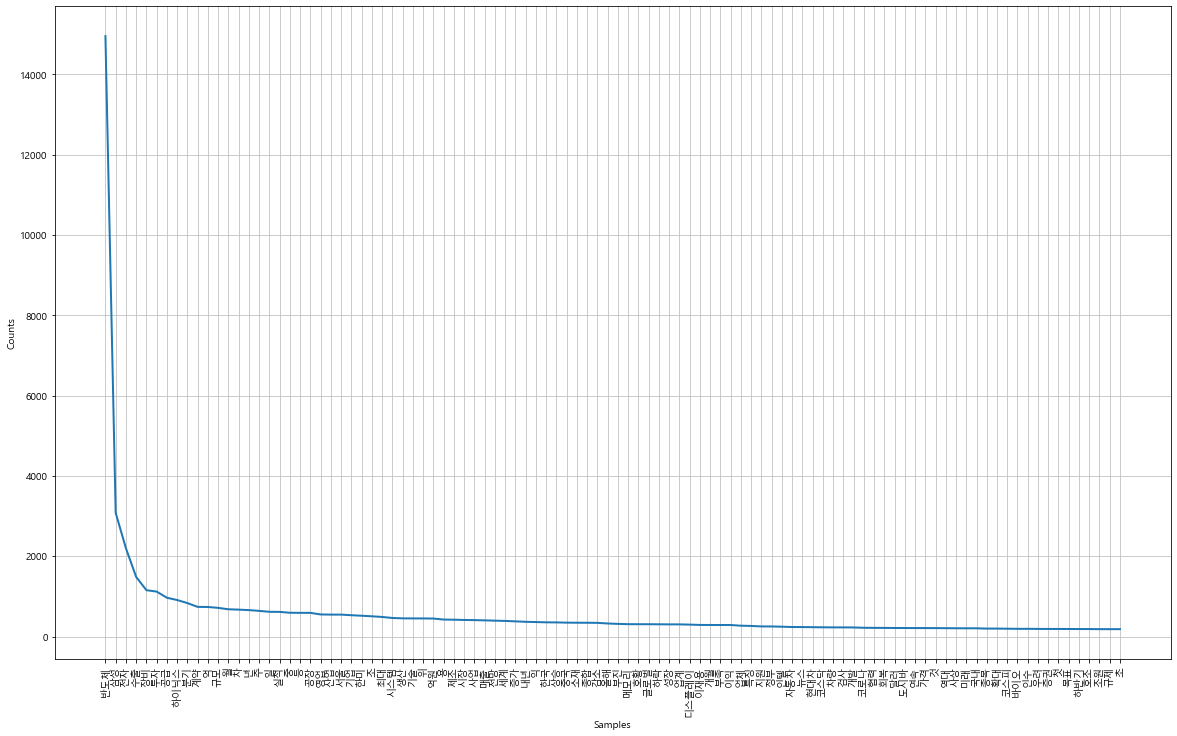

In [148]:
# stop_list 설정
words = nltk.Text(sum)
plt.figure(figsize=(20,12))
words.plot(100)        # 많이 사용된 단어 50개를 보여주기
plt.show()

In [147]:
# 불용어 지정
stopwords = "분기 억 월 차 년 중 주 일 등 조 억원 용 익 위 개월 이재용 것 조원 초 하반기"
stop_list = stopwords.split()

# sopt_list에 없는 단어만 추출 > 리스트를 만들 것
words_list = [word for word in sum if word not in stop_list]

In [125]:
# 빈도수가 200 이상인 단어 10개
data = words.vocab().most_common(200)
data[:10]

[('반도체', 44793),
 ('삼성', 9166),
 ('전자', 6544),
 ('수출', 4495),
 ('장비', 3581),
 ('투자', 3312),
 ('공급', 2984),
 ('하이닉스', 2713),
 ('분기', 2485),
 ('계약', 2302)]

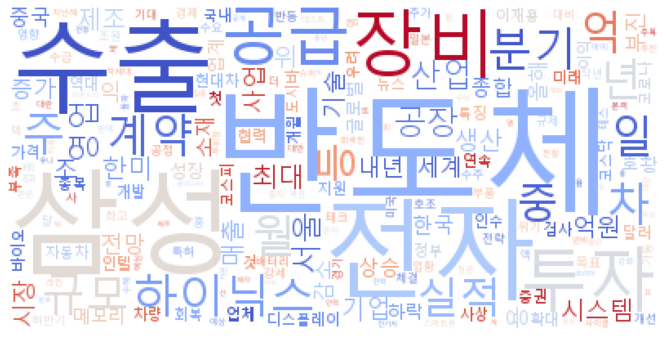

In [149]:
wc = WordCloud(
    font_path='c:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.2, background_color='white',
    colormap='coolwarm'
).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis('off')
plt.show()

### 7-2. test_data

In [151]:
# test_data > nouns 컬럼 > 0번째 데이터의 단어 출력
test_data.nouns.to_list()[0].split()

['자동차', '가전', '전방', '위로', '번지', '반도체', '공급', '대란']

In [152]:
# test_data의 길이 확인
len(test_data.nouns.to_list())

14611

In [153]:
nouns_list = []

for i in range(0, len(test_data.nouns.to_list())):
    noun = test_data.nouns.to_list()[i].split()
    nouns_list.append(noun)

In [154]:
sum = []

for i in range(0, len(nouns_list)):
    sum += nouns_list[i]

In [155]:
# 가장 많이 나온 단어 100개 저장
counts = Counter(sum)
tags = counts.most_common(100)

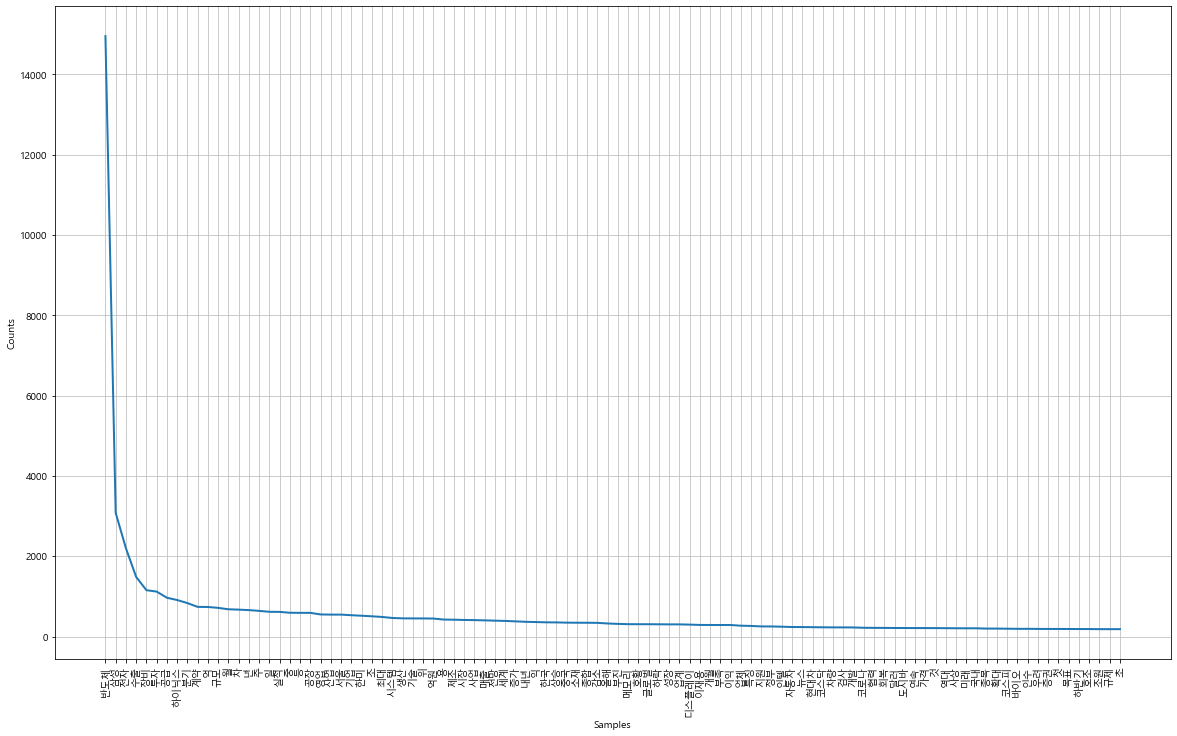

In [156]:
words = nltk.Text(sum)
plt.figure(figsize=(20,12))
words.plot(100)        # 많이 사용된 단어 50개를 보여주기
plt.show()

In [158]:
# 불용어 지정
stopwords = "억 월 차 년 주 일 중 등 조 취 억원 용 내년 익 올해 업계 개월 이재용 특징 달러 것 첫 조원 초"
stop_list = stopwords.split()

# sopt_list에 없는 단어만 추출 > 리스트를 만들 것
words_list = [word for word in sum if word not in stop_list]

In [159]:
# 빈도수가 200 이상인 단어 10개
data = words.vocab().most_common(200)
data[:10]

[('반도체', 14951),
 ('삼성', 3082),
 ('전자', 2199),
 ('수출', 1484),
 ('장비', 1155),
 ('투자', 1120),
 ('공급', 967),
 ('하이닉스', 910),
 ('분기', 834),
 ('계약', 739)]

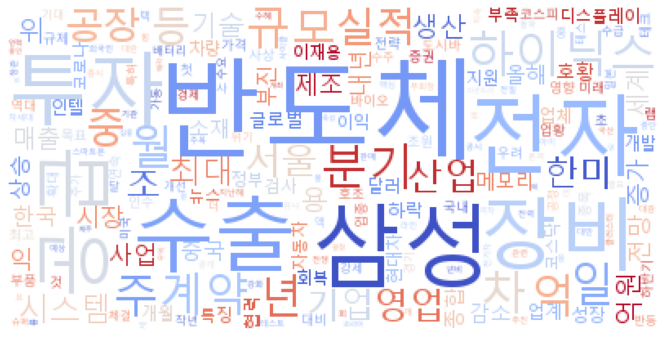

In [160]:
wc = WordCloud(
    font_path='c:/Windows/Fonts/malgun.ttf',
    relative_scaling=0.2, background_color='white',
    colormap='coolwarm'
).generate_from_frequencies(dict(data))

plt.figure(figsize=(12,6))
plt.imshow(wc)
plt.axis('off')
plt.show()